In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Please refer to our report for the interpretation of the results. 

In [2]:
test_DF = pd.read_csv("/home/jupyter/test_DF.csv", sep = "\t", encoding= "utf-8")
test_DF.head()

,pid,track_id,label
0,102312,310283,1
1,14157,26349,1
2,113235,312440,1
3,129834,20220,1
4,124700,16483,1


In [3]:
def makeDF(testDF, predictionsDF):
    pred_df = pd.DataFrame({
    'user_id': np.array(testDF['pid']),
    'item_id': np.array(testDF["track_id"]),
    'prediction': predictionsDF.flatten()
    })
    return pred_df

In [4]:
def topk_HR(predicted_DF, K, thresholds):
    sorted_predictions = predicted_DF.groupby('user_id').apply(lambda x: x.sort_values(by='prediction', ascending=False)).reset_index(drop=True)
    topk_recommendations = sorted_predictions.groupby('user_id').head(K)
    toFilter = topk_recommendations.copy()
    toFilter.loc[:, 'label'] = (toFilter['prediction'] > thresholds).astype(int)
    hit_count = toFilter.groupby('user_id')['label'].agg([('hit_rate', lambda x: sum(x == 1))]).reset_index()
    hit_count['HR'] = hit_count['hit_rate'].apply(lambda x: x/K)
    HRvalue = hit_count['HR'].mean()
    return HRvalue

In [5]:
def dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    return np.sum(r / np.log2(np.arange(2, len(r) + 2)))

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.0
    return dcg_at_k(r, k) / dcg_max

def average_ndcg(predicted_df, k, threshold):
    ndcg_values = []
    for user_id in predicted_df['user_id'].unique():
        user_data = predicted_df[predicted_df['user_id'] == user_id]
        relevance = (user_data['prediction'] > threshold).astype(int).tolist()
        ndcg_values.append(ndcg_at_k(relevance, k))
    avg_ndcg = np.mean(ndcg_values)
    return avg_ndcg

In [27]:
latent_prediction = []
list_direc = os.listdir("/home/jupyter/model_results/")
for direct in list_direc:
    if direct.startswith('latent') and direct.endswith('npy'):
        path = '/home/jupyter/model_results/' + direct
        basename, _ = direct.split(".")
        fread = np.load(path)
        latent_prediction.append({str(basename): fread})

In [28]:
prediction_df_dict = {}
for dict_ in latent_prediction:
    for key, value in dict_.items():
        df = makeDF(testDF = test_DF, predictionsDF = value)
        prediction_df_dict[key] = df

In [29]:
prediction_df_dict['latent_64'].head(5)

,user_id,item_id,prediction
0,102312,310283,0.674561
1,14157,26349,0.996863
2,113235,312440,0.983125
3,129834,20220,0.016977
4,124700,16483,0.959838


In [30]:
MLP_prediction = []
list_direc = os.listdir("/home/jupyter/model_results/")
for direct in list_direc:
    if direct.startswith('MLP') and direct.endswith('npy'):
        path = '/home/jupyter/model_results/' + direct
        basename, _ = direct.split(".")
        fread = np.load(path)
        MLP_prediction.append({str(basename): fread})

In [31]:
MLP_prediction[0]

{'MLP_6': array([[0.52426076],
        [0.00675892],
        [0.99973017],
        ...,
        [0.998566  ],
        [1.        ],
        [0.9999584 ]], dtype=float32)}

In [32]:
prediction_df_dict_MLP = {}
for dict_ in MLP_prediction:
    for key, value in dict_.items():
        df = makeDF(testDF = test_DF, predictionsDF = value)
        prediction_df_dict_MLP[key] = df

In [34]:
prediction_df_dict_MLP['MLP_0'].head(5)

,user_id,item_id,prediction
0,102312,310283,0.962956
1,14157,26349,0.994322
2,113235,312440,0.742920
3,129834,20220,0.070834
4,124700,16483,0.997056


In [35]:
items = [item for item in prediction_df_dict.items()]
HRresultsList = []
K = [100, 50, 30]
for k in tqdm(K):
    HRresults = {}
    for tuple_ in items:
        name, df = tuple_
        HRresults[name] = topk_HR(df, k, 0.85)
    HRresultsList.append(HRresults)

100%|██████████| 3/3 [00:35<00:00, 11.91s/it]


In [37]:
HRresultsList

[{'latent_64': 0.4839627208908255,
  'latent_8': 0.46499636891793755,
  'latent_32': 0.48307673686758656,
  'latent_128': 0.4781384652626483,
  'latent_16': 0.46528201404018393},
 {'latent_64': 0.7305833938513677,
  'latent_8': 0.7093536673928831,
  'latent_32': 0.731358024691358,
  'latent_128': 0.7251997095134349,
  'latent_16': 0.7102783829581215},
 {'latent_64': 0.8724683288953442,
  'latent_8': 0.8519406116356008,
  'latent_32': 0.8737271040103285,
  'latent_128': 0.8672476397966595,
  'latent_16': 0.8525942064068426}]

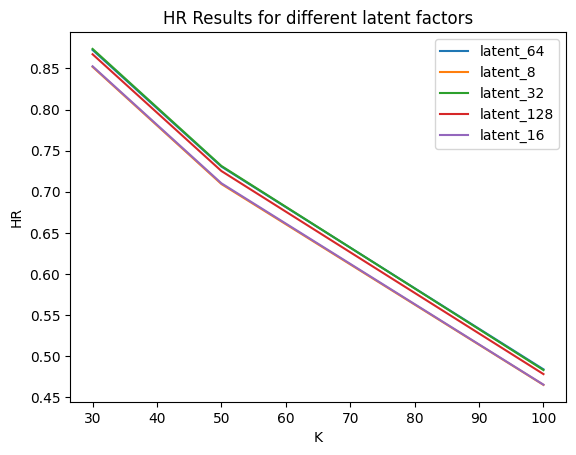

In [39]:
K = [100, 50, 30]
for i, (name, values) in enumerate(HRresultsList[0].items()):
    plt.plot(K, [res[name] for res in HRresultsList], label=name)

# Setting up the plot
plt.title('HR Results for different latent factors')
plt.xlabel('K')
plt.ylabel('HR')
plt.legend()

# Displaying the plot
plt.show()

In [40]:
NDCGresultsList = []

K = [100, 50, 30]
for k in K:
    NDCGresults = {}
    for tuple_ in items:
        name, df = tuple_
        NDCGresults[name] = average_ndcg(df, k, 0.9)
    NDCGresultsList.append(NDCGresults)

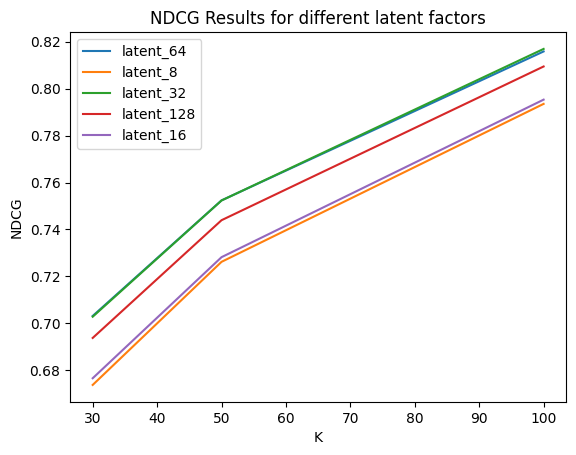

In [42]:
K = [100, 50, 30]
for i, (name, values) in enumerate(NDCGresultsList[0].items()):
    plt.plot(K, [res[name] for res in NDCGresultsList], label=name)

# Setting up the plot
plt.title('NDCG Results for different latent factors')
plt.xlabel('K')
plt.ylabel('NDCG')
plt.legend()

# Displaying the plot
plt.show()

In [43]:
items = [item for item in prediction_df_dict_MLP.items()]
HRresultsList_MLP = []
K = [100, 50, 30]
for k in tqdm(K):
    HRresults = {}
    for tuple_ in items:
        name, df = tuple_
        HRresults[name] = topk_HR(df, k, 0.85)
    HRresultsList_MLP.append(HRresults)

100%|██████████| 3/3 [00:50<00:00, 16.78s/it]


In [44]:
HRresultsList_MLP

[{'MLP_6': 0.5196586782861293,
  'MLP_1': 0.4677148390220286,
  'MLP_5': 0.5128951827644638,
  'MLP_0': 0.4652335996126846,
  'MLP_2': 0.4648753328491891,
  'MLP_3': 0.47046719922536917,
  'MLP_4': 0.4831348341805858},
 {'MLP_6': 0.7689760348583878,
  'MLP_1': 0.7135850883563303,
  'MLP_5': 0.7614717985959817,
  'MLP_0': 0.7105398208666182,
  'MLP_2': 0.7093536673928831,
  'MLP_3': 0.7157056402808036,
  'MLP_4': 0.7307528443476156},
 {'MLP_6': 0.905519244734931,
  'MLP_1': 0.856548051319293,
  'MLP_5': 0.8993060598725087,
  'MLP_0': 0.854643750504317,
  'MLP_2': 0.8524408940530944,
  'MLP_3': 0.858880012910514,
  'MLP_4': 0.8733236504478334}]

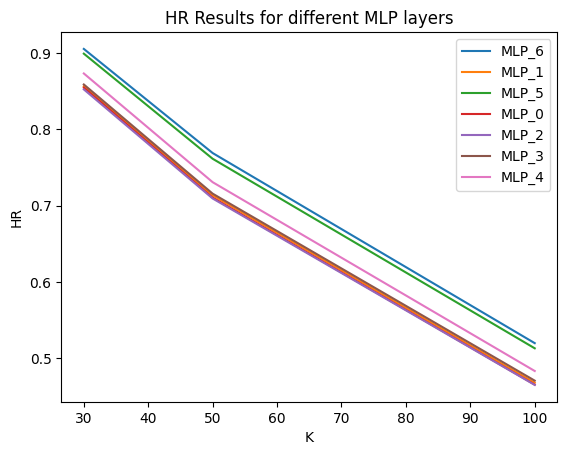

In [45]:
K = [100, 50, 30]
for i, (name, values) in enumerate(HRresultsList_MLP[0].items()):
    plt.plot(K, [res[name] for res in HRresultsList_MLP], label=name)

# Setting up the plot
plt.title('HR Results for different MLP layers')
plt.xlabel('K')
plt.ylabel('HR')
plt.legend()

# Displaying the plot
plt.show()

In [46]:
NDCGresultsList_MLP = []

K = [100, 50, 30]
for k in K:
    NDCGresults = {}
    for tuple_ in items:
        name, df = tuple_
        NDCGresults[name] = average_ndcg(df, k, 0.9)
    NDCGresultsList_MLP.append(NDCGresults)

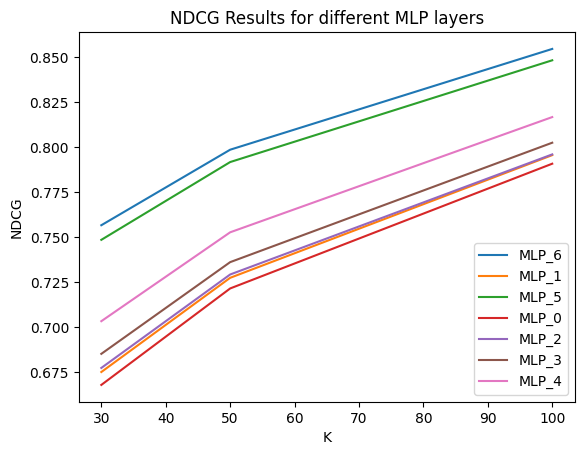

In [47]:
K = [100, 50, 30]
for i, (name, values) in enumerate(NDCGresultsList_MLP[0].items()):
    plt.plot(K, [res[name] for res in NDCGresultsList_MLP], label=name)

# Setting up the plot
plt.title('NDCG Results for different MLP layers')
plt.xlabel('K')
plt.ylabel('NDCG')
plt.legend()

# Displaying the plot
plt.show()

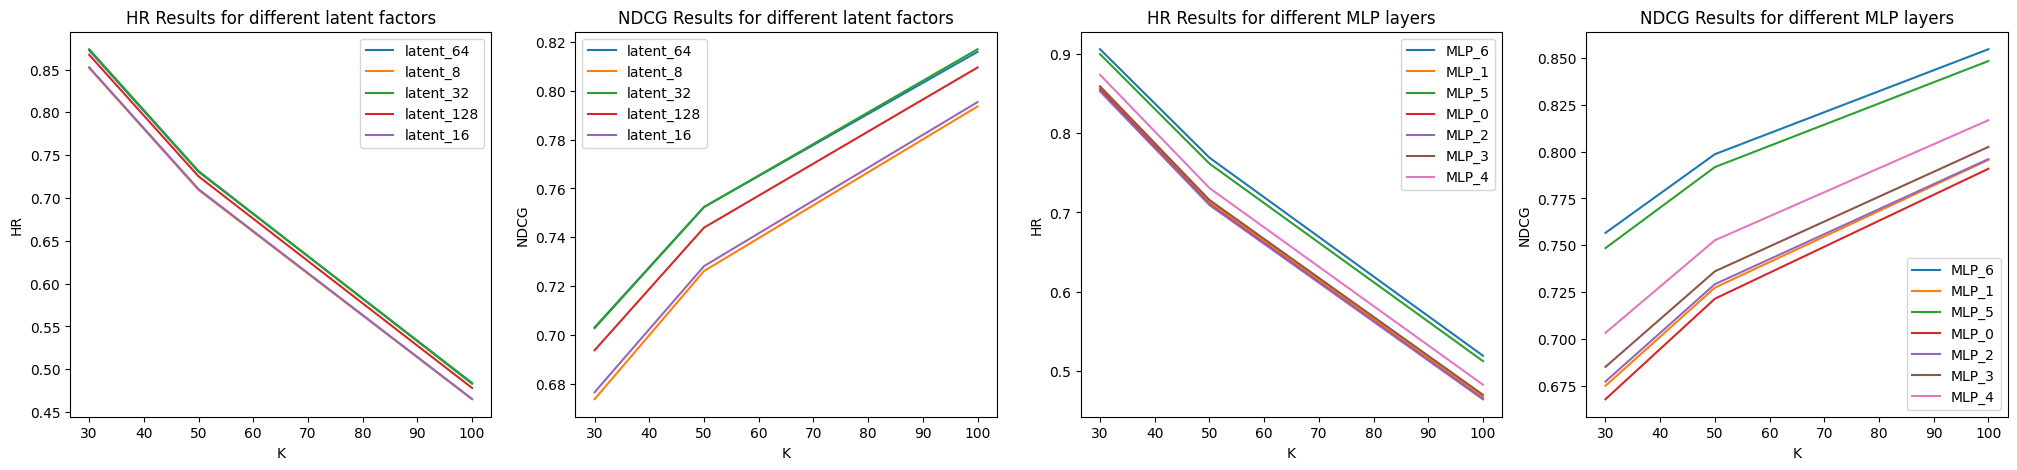

In [50]:
K = [100, 50, 30]

# Creating the subplot
fig, axs = plt.subplots(1, 4, figsize=(25, 5))

# Plotting HR results for different latent factors
for i, (name, values) in enumerate(HRresultsList[0].items()):
    axs[0].plot(K, [res[name] for res in HRresultsList], label=name)
axs[0].set_title('HR Results for different latent factors')
axs[0].set_xlabel('K')
axs[0].set_ylabel('HR')
axs[0].legend()

# Plotting NDCG results for different latent factors
for i, (name, values) in enumerate(NDCGresultsList[0].items()):
    axs[1].plot(K, [res[name] for res in NDCGresultsList], label=name)
axs[1].set_title('NDCG Results for different latent factors')
axs[1].set_xlabel('K')
axs[1].set_ylabel('NDCG')
axs[1].legend()

# Plotting HR results for different MLP layers
for i, (name, values) in enumerate(HRresultsList_MLP[0].items()):
    axs[2].plot(K, [res[name] for res in HRresultsList_MLP], label=name)
axs[2].set_title('HR Results for different MLP layers')
axs[2].set_xlabel('K')
axs[2].set_ylabel('HR')
axs[2].legend()

# Plotting NDCG results for different MLP layers
for i, (name, values) in enumerate(NDCGresultsList_MLP[0].items()):
    axs[3].plot(K, [res[name] for res in NDCGresultsList_MLP], label=name)
axs[3].set_title('NDCG Results for different MLP layers')
axs[3].set_xlabel('K')
axs[3].set_ylabel('NDCG')
axs[3].legend()

# Displaying the plot
plt.show()